# [West-Nile-Virus Kaggle Competition](https://www.kaggle.com/c/predict-west-nile-virus)

![image](http://www.nataliedee.com/073107/everybody-hates-you.jpg)

From Kaggle:

> [West Nile virus](https://www.cdc.gov/westnile/) is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

> In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

> Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

> Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

Tasks for this session will be to:

* Download main dataset.
* Understand differences between test and train dataset.
* Explore data to understand what's predictive of WNV.
* Look at what others have done in terms of feature engineering.
* Come up with some features of our own.

In [1]:
%pylab inline
from IPython.display import display, HTML
import os
import seaborn as sns
import pandas as pd
subm_folder = './submissions'
from sklearn.cluster import KMeans
import datetime

Populating the interactive namespace from numpy and matplotlib


# Introduction
___
Watch this short video describing how WNV was introduced into the US and how quickly it spread.

In [3]:
# Youtube introduction video
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/EVk5rfIA4kU?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Competition overview
* Predict presence of West Nile Virus from mosquito catch data.
* Data from Chicago during summer between 2007-2011.
* Also data available from spraying and weather.
* Competition ran April-June 2015.
* Can still make submissions.

### Competition evaluation

Goal is for each trap location and entry to predict (give a probability) of the presence of WNV. Evaluated using the Area under curve ([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), which is the integral of the true positive rate versus the false positive rate.

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/600px-ROC_curves.svg.png)

## Disease overview
* Flavivirus: Japanese Encephalitis, Dengue, Zika, Yellow fever,
* 1 in 150 infected develop serious illness.
* No vaccine, mosquito control main intervention.
* Birds main host, also in reptiles, amphibians and mammals (including humans).

# Data Exploration

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
#print lengths of dataframes
print (len(df_test.index))
print (len(df_train.index))

116293
10506


In [4]:
df_train.head(n=3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [5]:
df_test.head(n=3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Check what data is not included in the test set

In [6]:
set(df_test.columns).symmetric_difference(set(df_train.columns))

{'Id', 'NumMosquitos', 'WnvPresent'}

## Spatial data plot

### Initial plot

We'll use a 2D histogram to plot the geographic location of the training dataset and overlay where the test data were recorded


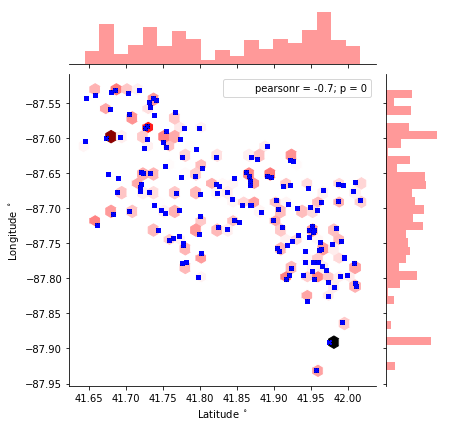

In [7]:
plt.figure(figsize=(10,8));
graph = sns.jointplot(x=df_train['Latitude'], y=df_train['Longitude'], kind="hex",color='r');

graph.x = df_test['Latitude']
graph.y = df_test['Longitude']
graph.plot_joint(plt.scatter, marker='x', c='b', s=10);
plt.xlabel('Latitude $^\circ$');
plt.ylabel('Longitude $^\circ$');


Lots of overlaps. Let's look at unique locations

In [8]:
addresses = df_train.groupby('Address').groups
print('Total training locations: {} out of {} entries'.format(len(addresses.keys()),len(df_train.index)))

addresses = df_test.groupby('Address').groups
print('Total test locations: {} out of {} entries'.format(len(addresses.keys()),len(df_test.index)))

Total training locations: 138 out of 10506 entries
Total test locations: 151 out of 116293 entries


### Use folium to plot clustered data points

[folium](http://folium.readthedocs.io/en/latest/) is a library that creates interactive visualisations for geographic data.

In order to use this we first need to geographically cluster the data. We'll do this using k-means.

In [9]:
ad_df = df_train.groupby('Address').mean()

X = ad_df[['Latitude','Longitude']].get_values()
kmeans = KMeans(n_clusters=20, random_state=0).fit(X)
labels = kmeans.labels_

ad_df['label'] = labels

ad_df = ad_df.reset_index()

Now we set up the folium map by creating markers for each unique address and providing the average number of mosquitoes and probability of West Nile Virus being present.

In [11]:
import folium
from folium.plugins import MarkerCluster


latm = df_train['Latitude'].mean()
longm = df_train['Longitude'].mean()
m = folium.Map(location=[latm, longm])
i = 0
for label in labels:
    marker_cluster = MarkerCluster().add_to(m)
    cluster_addresses = ad_df[ad_df['label']==label]
    for index,row in cluster_addresses.iterrows():
            
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup='Prob. WNV: {:.2f}, average mosquitoes: {:.2f}'.format(row['WnvPresent'],row['NumMosquitos'])
        ).add_to(marker_cluster)
        i+=1

In [12]:
m

## Explore mosquito species feature

Not all mosquito species can incubate WNV. Some species will be more competent at transmission than others, so this should be an informative feature

In [13]:
def speciesCount(df,label='train'):
    df_species = df.groupby('Species').count().reset_index()
    df_species['Data'] = label
    df_species['Count'] = df_species['Date']
    df_species = df_species[['Count','Data','Species']]
    return df_species
dfsc = speciesCount(df_train)
dfsc = dfsc.append(speciesCount(df_test,label='test'))

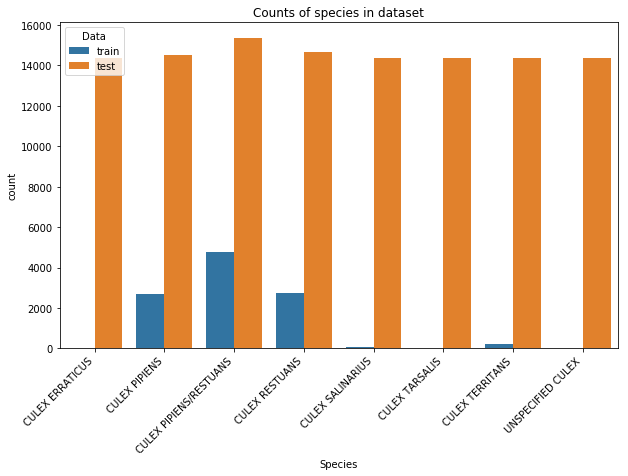

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(x="Species", y="Count", hue="Data", data=dfsc);
plt.title('Counts of species in dataset');
plt.xticks(rotation=45,ha='right');
plt.ylabel('count');

In [15]:
def speciesWnvProb(df):
    df_species = df.groupby('Species').mean().reset_index()
    df_species['Prob_WNV'] = df_species['WnvPresent']
    df_species = df_species[['Prob_WNV','Species']]
    return df_species
dfsc = speciesWnvProb(df_train)


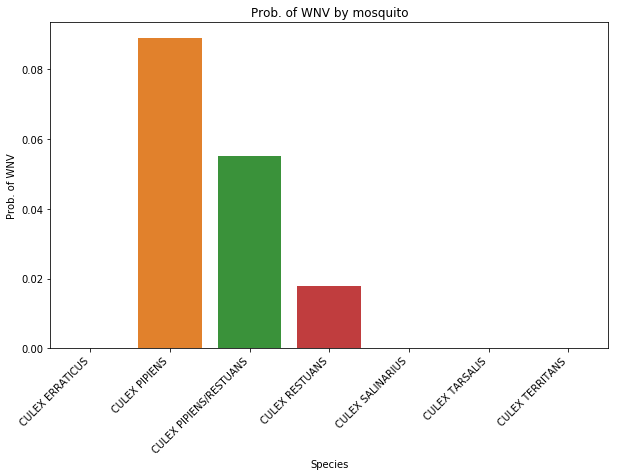

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(x="Species", y="Prob_WNV", data=dfsc);
plt.title('Prob. of WNV by mosquito');
plt.xticks(rotation=45,ha='right');
plt.ylabel('Prob. of WNV');

Only _Culex pipiens_ and _Culex restuans_ transmit WNV. Can probably remove all other mosquito entries

## Explore how data and prevalence are distributed in time

### Group data by date and explore where test and train data lie in time

In [17]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [18]:
ndf = df_train.groupby(['Date']).count().reset_index()
ndf['Date'] = pd.to_datetime(ndf['Date'])

mdf = df_test.groupby(['Date']).count().reset_index()
mdf['Date'] = pd.to_datetime(mdf['Date'])

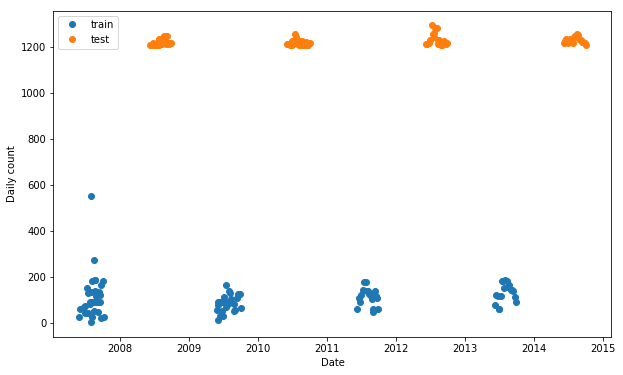

In [19]:
plt.figure(figsize=(10,6));
plt.plot(ndf['Date'],ndf['Trap'],'o',label='train');
plt.plot(mdf['Date'],mdf['Trap'],'o',label='test');
plt.xlabel('Date');
plt.ylabel('Daily count');
plt.legend();

* The test/train split is not done randomly but rather by year.
* This means for some years we have no idea about how much WNV there was present.
* This makes it a much more challenging problem.

### Prevalence of WNV throughout year (where we have data)

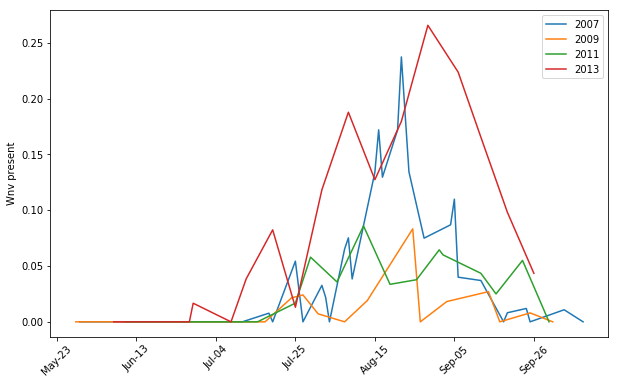

In [20]:
means = df_train.groupby('Date').mean().reset_index();
means['Date'] = pd.to_datetime(means['Date']);
means['Year'] = means['Date'].dt.year

plt.figure(figsize=(10,6));
for year in means['Year'].unique().astype(str):
    yr = means[(means['Date'] > year+'-01-01') & (means['Date'] < year+'-12-30')]
    dates = pd.to_datetime(yr['Date'].map(lambda x: x.strftime('2009-%m-%d')))
    
    plt.plot(dates,yr['WnvPresent'],label=year);
plt.xticks(rotation=45);
plt.ylabel('Wnv present');
plt.legend();
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'));

## Explore no. of mosquito counts

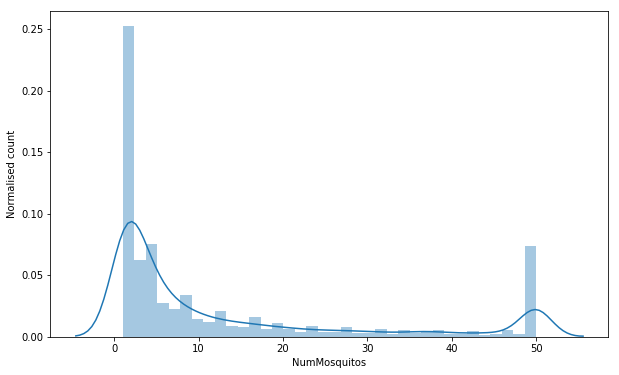

In [21]:
plt.figure(figsize=(10,6));
sns.distplot(df_train['NumMosquitos']);
plt.ylabel('Normalised count');

Data is capped at 50. Really, we should sum by trap in order to get the true distribution of mosquitos

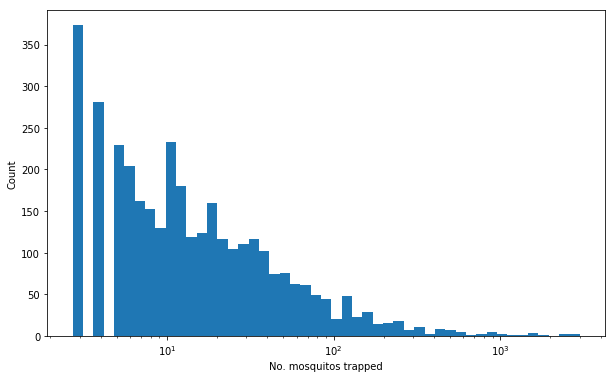

In [22]:
mosCount = df_train.groupby(['Trap','Date']).sum()['NumMosquitos'].get_values()
bins = np.linspace(1.,np.max(np.log(mosCount)));
bins = np.exp(bins)

plt.figure(figsize=(10,6));
plt.hist(mosCount,bins=bins);
plt.xscale('log');plt.xlabel('No. mosquitos trapped');
plt.ylabel('Count');

Some traps caught over 1000 mosquitoes in one day!

### Compare mosquito counts to presence of WNV

In [23]:
group_df = df_train.groupby(['Trap','Date']).sum().reset_index()
group_df['WnvPresent'] = np.minimum(group_df['WnvPresent'],1)

Create a function to plot the presence of WNV grouped by a given feature:

In [24]:
def plotGroupedBy(col,df=df_train):
    wnv_present = df.groupby([col]).sum()['WnvPresent']>0
    present_counts = df.groupby([col]).count()['WnvPresent'][wnv_present].get_values()
    npresent_counts = df.groupby([col]).count()['WnvPresent'][-wnv_present].get_values()
    plt.hist([present_counts,npresent_counts], 50, stacked=True,label=['present','not present'])
    plt.legend();

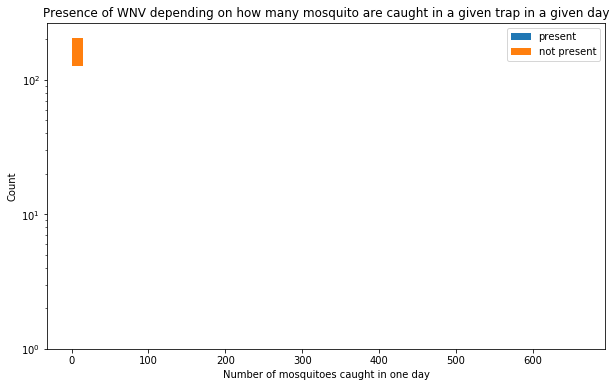

In [26]:
plt.figure(figsize=(10,6));
plotGroupedBy('NumMosquitos',df=group_df);
plt.title('Presence of WNV depending on how many mosquito are caught in a given trap in a given day');
plt.yscale('log');
plt.ylabel('Count');
plt.xlabel('Number of mosquitoes caught in one day');

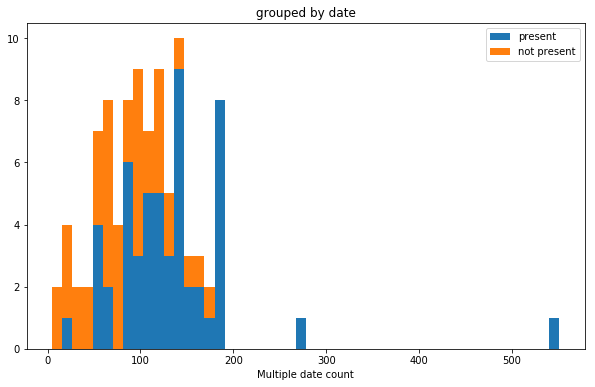

In [27]:
plt.figure(figsize=(10,6));
plotGroupedBy('Date');
plt.title('grouped by date');
plt.xlabel('Multiple date count');

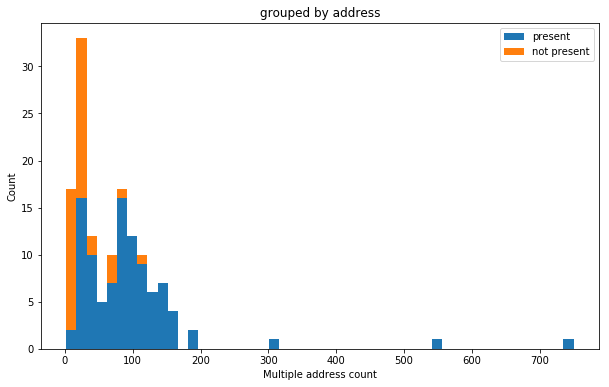

In [28]:
plt.figure(figsize=(10,6));
plotGroupedBy('Address');
plt.title('grouped by address');
plt.xlabel('Multiple address count');
plt.ylabel('Count');

Can summarize as:

* The more mosquitos caught on a given day, the more likely WNV is present.
* The more mosquitos caught on a given location, the more likely WNV is present.
* The more mosquitos caught in a given trap on a given day, the more likely WNV is present.

## Feature engineering

In [29]:
# DateCount
def createGroupByFeature(col,df=df_train):
    dt_count = df.groupby(col).count()[['WnvPresent']] #get mutiple counts on a certain date
    dt_count.columns = ['DateCount'] #create new column for how many times date repeated.
    res_df = pd.merge(df, dt_count, how='inner', left_on=col, right_index=True)
    cnt_pred = np.array(res_df['DateCount'])
    cnt_pred = 1.0*(cnt_pred - cnt_pred.min()) / (cnt_pred.max() - cnt_pred.min()) #normalize value to get prob.
    return cnt_pred


In [30]:
train = df_train.copy()
train['Date_Feature'] = createGroupByFeature('Date')

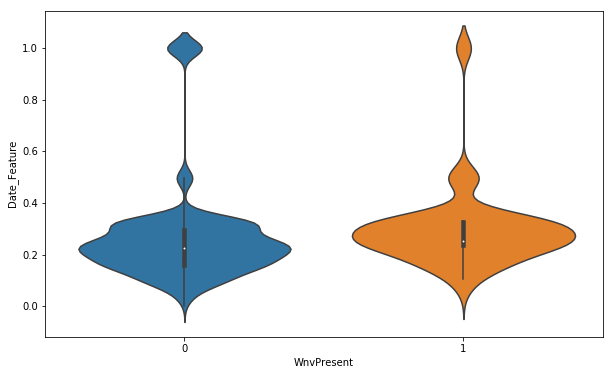

In [31]:
plt.figure(figsize=(10,6));
sns.violinplot(x='WnvPresent',y='Date_Feature',data=train);

### See how well this one feature predicts presence of WNV
We'll use the AUC metric as defined in the competition evaluation

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
def plotAUC(feature,true_label):
    #false positive rate, true positive rate
    fpr, tpr, _ = roc_curve(true_label,feature)
    #Receiver Operator Curve, Area Under Curve
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,6));
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.legend(loc="lower right");

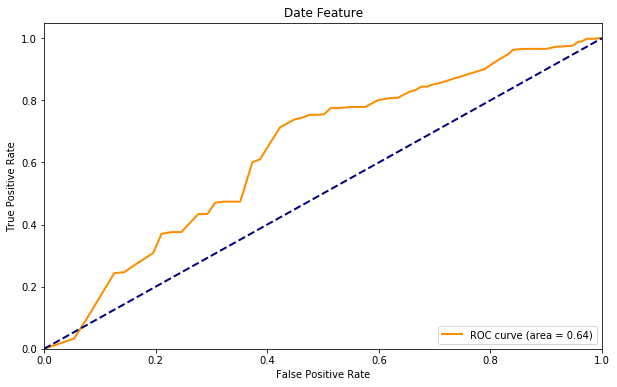

In [34]:
plotAUC(train['Date_Feature'],train['WnvPresent']);
plt.title('Date Feature');

In [35]:
train['Address_Feature'] = createGroupByFeature('Address')

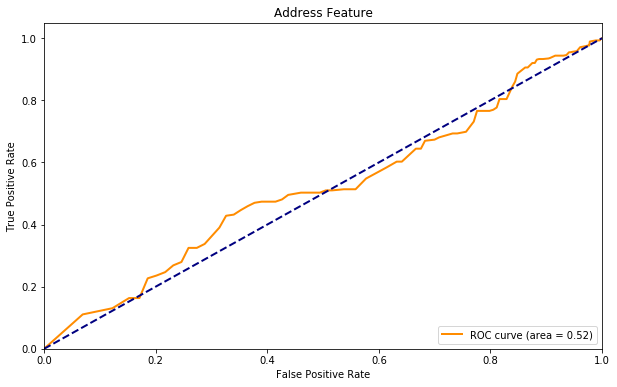

In [36]:
plotAUC(train['Address_Feature'],train['WnvPresent']);
plt.title('Address Feature');

In [37]:
train['Month'] = train['Date'].dt.month
train['Month_Feature'] = createGroupByFeature('Month',df=train)

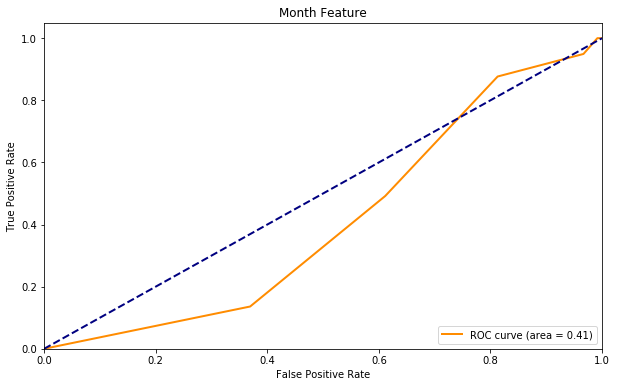

In [38]:
plotAUC(train['Month_Feature'],train['WnvPresent']);
plt.title('Month Feature');

In [39]:
train['Species_Feature'] = createGroupByFeature('Species',df=train)

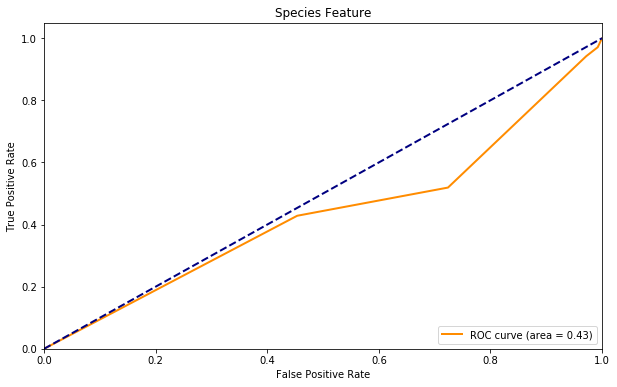

In [40]:
plotAUC(train['Species_Feature'],train['WnvPresent']);
plt.title('Species Feature');